# Introduction

Stochastic timeseries can be characterized by the noise color, which is defined by the slope of the power spectral density. The more negative this slope is, the more structure there is in the timeseries. This also results in a more slowly decreasing auto-correlation function.

## Standard imports

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

import time
np.random.seed(int(time.time()))

## Specific imports

In [16]:
from generate_timeseries import Timeseries
from noise_properties_plotting import PlotTimeseriesComparison, example_noise_fit, noise_cmap_ww, noise_lim

## Settings figures

In [2]:
from elife_settings import set_elife_settings, ELIFE

set_elife_settings()

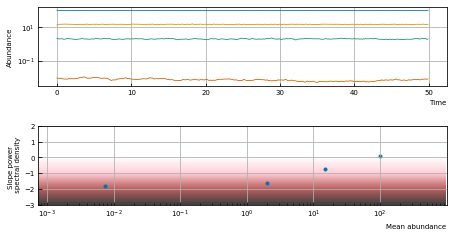

In [10]:
new = False #True

N = 4

params = {}

steadystate = np.array([0.01, 2, 15, 100]).reshape([N,1]) #np.logspace(-1,2,N).reshape([N,1])

# no interaction
omega = np.zeros([N, N]); np.fill_diagonal(omega, -1)

params['interaction_matrix'] = omega

# no immigration
params['immigration_rate'] = np.zeros([N, 1])

# different growthrates determined by the steady state
params['growthrate'] = - (omega).dot(steadystate)


params['initial_condition'] = np.copy(steadystate) * np.random.normal(1,0.1,steadystate.shape)

params['noise'] = 1e-1

params['noise_linear'] = 1e-1
params['noise_sqrt'] = 1e-2

files_ts_impl = ['results/without_interactions/timeseries_autocorrelation1.csv']

implementations = []

def create_new_files():
    for f in files_ts_impl:
        if os.path.exists(f):
            os.remove(f)
        
        Timeseries(params, f = f, noise_implementation = NOISE.LANGEVIN_LINEAR, 
                            dt = 0.01, tskip=4, T=50.0, seed=int(time.time()))

if new:
    create_new_files()
    
fig = plt.figure(figsize=(18/2.54,10/2.54))

PlotTimeseriesComparison(files_ts_impl, composition = ['ts', 'nc'], fig=fig)

plt.show()

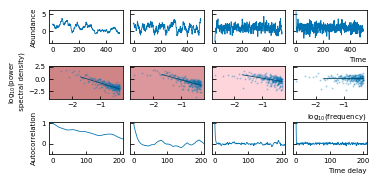

In [17]:
tss = pd.read_csv('results/without_interactions/timeseries_autocorrelation1.csv')

fig = plt.figure(figsize=(ELIFE.TEXTWIDTH,2.5))
gs = gridspec.GridSpec(3,N, hspace=0.7, wspace=0.1, top=0.95, 
                       bottom=0.15, left=0.15, right=0.95)

autocorrelation = {}

for species in ['species_%d' % i for i in range(1,N+1)]:
    R = np.zeros(len(tss))
    
    ts = tss[species].values.flatten()
    mean = np.mean(ts)
    std = np.std(ts)
    
    for i in range(len(ts)):
        R[i] = np.mean((ts[0:len(ts)-i] - mean)*(ts[i:]-mean))/std**2
    
    autocorrelation[species] = R
    
for i in range(N):
    ts = tss['species_%d' % (i+1)][:500]
    ts = ts - np.mean(ts)
    ts = ts/np.std(ts)
    ts += 1
    
    ax_ts = fig.add_subplot(gs[i], sharey=ax_ts if i > 0 else None)
    
    ax_ts.plot(range(len(ts)), ts)
    if i == N-1:
        ax_ts.set_xlabel('Time', ha='right', x=1)
    ax_ts.set_ylabel('Abundance')
    
    ax_psd = fig.add_subplot(gs[N+i], sharey=ax_psd if i > 0 else None)
    
    slope = example_noise_fit(ax_psd, ts)
    
    if slope > 0:
        slope = 0
        
    c = noise_cmap_ww((slope - noise_lim[0])/(noise_lim[1]-noise_lim[0]))
    #ax_psd.set_facecolor(c) #, alpha=0.4)
    
    if i < N-1:
        ax_psd.set_xlabel('')
    elif i == N-1:
        ax_psd.set_xlabel('log$_{10}$(frequency)', x=1, ha='right')
        
    ax_psd.patch.set_facecolor(c)
    ax_psd.patch.set_alpha(0.7)

    ax_corr = fig.add_subplot(gs[2*N+i], sharey=ax_corr if i > 0 else None)

    ax_corr.plot(np.arange(len(ts))[:500], autocorrelation['species_%d' % (i+1)][:500])
    ax_corr.set_xlim([-10,210])
    
    if i == N-1:
        ax_corr.set_xlabel('Time delay', ha='right', x=1)
    if i == 0:
        ax_corr.set_ylabel('Autocorrelation')
        ax_psd.set_ylabel('log$_{10}$(power \n spectral density)')
    
    if (i > 0):
        for ax in [ax_ts, ax_psd, ax_corr]:
            ax.set_ylabel('')
            ax.tick_params(axis='both', left=True, labelleft=False)
    
plt.show()